In [ ]:
import zipfile
import os
import shutil
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import file
from torchvision import models
import csv

In [ ]:
if not os.path.exists('data'):
    with zipfile.ZipFile('archive24.zip', 'r') as zip_ref: #загружаем очищенный датасет
        zip_ref.extractall('data')

In [ ]:
#создаем общие папки для типов кожи
input_folders = {
    '0': [
        '/content/data/Oily-Dry-Skin-Types/test/dry',
        '/content/data/Oily-Dry-Skin-Types/train/dry',
        '/content/data/Oily-Dry-Skin-Types/valid/dry'
    ],
    '1': [
       '/content/data/Oily-Dry-Skin-Types/test/normal',
        '/content/data/Oily-Dry-Skin-Types/train/normal',
        '/content/data/Oily-Dry-Skin-Types/valid/normal'
    ],
    '2': [
        '/content/data/Oily-Dry-Skin-Types/test/oily',
        '/content/data/Oily-Dry-Skin-Types/train/oily',
        '/content/data/Oily-Dry-Skin-Types/valid/oily'
    ]
}

output_folders = {
    '0': '/content/data/content/combined_dataset_final/0',
    '1': '/content/data/content/combined_dataset_final/1',
    '2': '/content/data/content/combined_dataset_final/2'
}

for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

In [ ]:
for class_id in input_folders:
    for source_folder in input_folders[class_id]:
        if os.path.exists(source_folder):
            for filename in os.listdir(source_folder):
                src_path = os.path.join(source_folder, filename)
                if os.path.isfile(src_path) and not filename.startswith('.'):
                    dst_path = os.path.join(output_folders[class_id], filename)
                    shutil.copy2(src_path, dst_path)

In [ ]:
class SkinDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {image_path}: {str(e)}")
            return self.__getitem__((idx + 1) % self.__len__())

In [ ]:
#собираем пути к изображениям и их соответствующие метки классов
all_image_paths = []
all_labels = []

for class_id in ['0', '1', '2']:
    class_dir = output_folders[class_id]
    image_names = [f for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f)) and not f.startswith('.')]

    for image_name in image_names:
        img_path = os.path.join(class_dir, image_name)
        all_image_paths.append(img_path)
        all_labels.append(int(class_id))

In [ ]:
#разделяем на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [ ]:
#аугментация для трейна и теста
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0))
    ], p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#создаем датасеты
train_dataset = SkinDataset(train_paths, train_labels, train_transform)
test_dataset = SkinDataset(test_paths, test_labels, test_transform)

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#загркжаем модель resnet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#переносим модель на gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#функции для обучения
def train_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_labels

In [ ]:
#создаем класс для ранней остановки
class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'best_model.pth')
        self.val_loss_min = val_loss


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scaler = GradScaler()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=5, verbose=True)

<ipython-input-14-85f1b71e169e>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#обучение
num_epochs = 30
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc, _, _ = validate(model, test_loader, criterion, device)

    scheduler.step(val_loss)
    early_stopping(val_loss, model)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_skin_model.pth')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-12-26b3c887ae53>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Validation loss decreased (inf --> 1.882247). Saving model...
Train Loss: 3.8639 | Train Acc: 40.01%
Val Loss: 1.8822 | Val Acc: 54.60%

Epoch 2/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Validation loss decreased (1.882247 --> 0.989067). Saving model...
Train Loss: 0.8696 | Train Acc: 59.10%
Val Loss: 0.9891 | Val Acc: 58.16%

Epoch 3/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Validation loss decreased (0.989067 --> 0.826716). Saving model...
Train Loss: 0.7129 | Train Acc: 69.32%
Val Loss: 0.8267 | Val Acc: 66.60%

Epoch 4/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Validation loss decreased (0.826716 --> 0.698556). Saving model...
Train Loss: 0.6117 | Train Acc: 75.89%
Val Loss: 0.6986 | Val Acc: 73.17%

Epoch 5/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.5716 | Train Acc: 76.78%
Val Loss: 0.7055 | Val Acc: 74.48%

Epoch 6/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.5034 | Train Acc: 79.69%
Val Loss: 0.7851 | Val Acc: 72.23%

Epoch 7/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Validation loss decreased (0.698556 --> 0.688533). Saving model...
Train Loss: 0.4623 | Train Acc: 81.19%
Val Loss: 0.6885 | Val Acc: 76.17%

Epoch 8/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.3838 | Train Acc: 84.29%
Val Loss: 0.7012 | Val Acc: 78.05%

Epoch 9/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.3905 | Train Acc: 84.71%
Val Loss: 0.7207 | Val Acc: 72.98%

Epoch 10/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Validation loss decreased (0.688533 --> 0.686626). Saving model...
Train Loss: 0.3451 | Train Acc: 87.05%
Val Loss: 0.6866 | Val Acc: 78.24%

Epoch 11/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.3031 | Train Acc: 88.46%
Val Loss: 0.7833 | Val Acc: 78.05%

Epoch 12/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Validation loss decreased (0.686626 --> 0.575619). Saving model...
Train Loss: 0.2979 | Train Acc: 89.40%
Val Loss: 0.5756 | Val Acc: 84.62%

Epoch 13/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.2613 | Train Acc: 90.48%
Val Loss: 0.7831 | Val Acc: 80.11%

Epoch 14/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.2252 | Train Acc: 91.89%
Val Loss: 0.6892 | Val Acc: 83.49%

Epoch 15/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


EarlyStopping counter: 3 out of 5
Train Loss: 0.2006 | Train Acc: 92.50%
Val Loss: 0.9103 | Val Acc: 79.74%

Epoch 16/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


EarlyStopping counter: 4 out of 5
Train Loss: 0.1991 | Train Acc: 92.64%
Val Loss: 0.6033 | Val Acc: 83.30%

Epoch 17/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Validation loss decreased (0.575619 --> 0.492461). Saving model...
Train Loss: 0.1477 | Train Acc: 94.47%
Val Loss: 0.4925 | Val Acc: 88.56%

Epoch 18/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.1171 | Train Acc: 95.97%
Val Loss: 0.5011 | Val Acc: 88.37%

Epoch 19/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Validation loss decreased (0.492461 --> 0.479550). Saving model...
Train Loss: 0.1146 | Train Acc: 96.34%
Val Loss: 0.4795 | Val Acc: 88.93%

Epoch 20/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.0868 | Train Acc: 96.81%
Val Loss: 0.4836 | Val Acc: 88.74%

Epoch 21/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.0958 | Train Acc: 96.95%
Val Loss: 0.4995 | Val Acc: 89.12%

Epoch 22/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EarlyStopping counter: 3 out of 5
Train Loss: 0.0872 | Train Acc: 96.86%
Val Loss: 0.5070 | Val Acc: 89.49%

Epoch 23/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Validation loss decreased (0.479550 --> 0.476176). Saving model...
Train Loss: 0.0768 | Train Acc: 97.19%
Val Loss: 0.4762 | Val Acc: 89.31%

Epoch 24/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


EarlyStopping counter: 1 out of 5
Train Loss: 0.0623 | Train Acc: 98.08%
Val Loss: 0.4861 | Val Acc: 89.12%

Epoch 25/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


EarlyStopping counter: 2 out of 5
Train Loss: 0.0717 | Train Acc: 97.89%
Val Loss: 0.5076 | Val Acc: 89.12%

Epoch 26/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


EarlyStopping counter: 3 out of 5
Train Loss: 0.0716 | Train Acc: 97.84%
Val Loss: 0.4872 | Val Acc: 89.87%

Epoch 27/30


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


EarlyStopping counter: 4 out of 5
Train Loss: 0.0557 | Train Acc: 98.45%
Val Loss: 0.5368 | Val Acc: 89.87%

Epoch 28/30


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

EarlyStopping counter: 5 out of 5
Train Loss: 0.0481 | Train Acc: 98.26%
Val Loss: 0.5234 | Val Acc: 89.68%
Early stopping triggered


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]



Classification Report:
              precision    recall  f1-score   support

      Type 0       0.90      0.82      0.85        65
      Type 1       0.88      0.94      0.91       242
      Type 2       0.92      0.88      0.90       226

    accuracy                           0.90       533
   macro avg       0.90      0.88      0.89       533
weighted avg       0.90      0.90      0.90       533



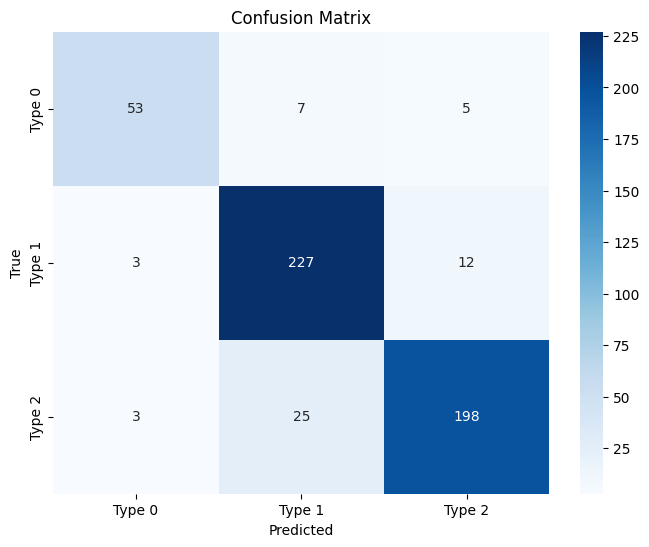

In [ ]:
val_loss, val_acc, all_preds, all_labels = validate(model, test_loader, criterion, device)

#смотрим отчет по качеству
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Type 0', 'Type 1', 'Type 2']))

#матрица ошибок
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, ['Type 0', 'Type 1', 'Type 2'])


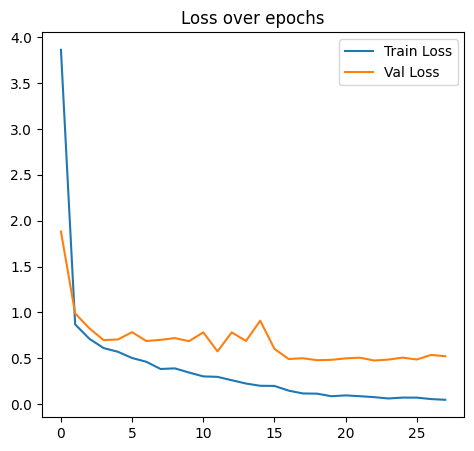

In [ ]:
#график изменения loss на всем процессе обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

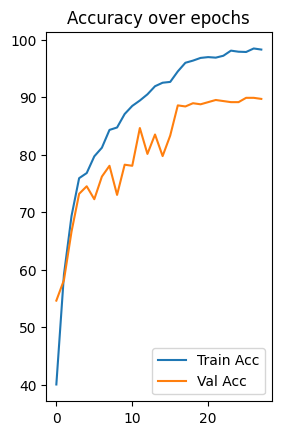

In [ ]:
#график изменения accuracy на всем процессе обучения
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

In [ ]:
#сохраняем и скачиваем получившуюся модель

torch.save(model.state_dict(), 'skin_type1905.pth')

files.download('skin_type1905.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#для дальнейшей работы загружаем нашу модель

model_path = '/content/skin_type1905 (1).pth'
model = torch.load(model_path, map_location='cuda:0')

In [ ]:
import torch
from torchvision import models

#создаем модель
model = models.resnet18(pretrained=False)

#загружаем веса
state_dict = torch.load("/content/skin_type1905 (1).pth", map_location="cpu")  # или "cuda"
model.load_state_dict(state_dict)

#переводим модель на gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def resize_with_padding(image, target_size=(214, 120)):
    original_size = image.size
    ratio = min(target_size[0] / original_size[0], target_size[1] / original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    image = image.resize(new_size, Image.Resampling.LANCZOS)

    #создаем новое изображение нужного размера и вставляем в центр
    new_img = Image.new("RGB", target_size, (0, 0, 0))
    paste_position = (
        (target_size[0] - new_size[0]) // 2,
        (target_size[1] - new_size[1]) // 2,
    )
    new_img.paste(image, paste_position)
    return new_img


In [ ]:
#фукнция для предсказания класса
def prediction_final(resnet_model, image_arr):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    acne_arr = []
    for i in image_arr:
        img = Image.open(i).convert("RGB")
        img = resize_with_padding(img, (214, 214))
        img_tensor = transform(img).unsqueeze(0)

        resnet_model.eval()
        model1 = resnet_model.to(device)

        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            logits = model1(img_tensor)
            probs = torch.softmax(logits, dim=1)
            print(probs)
            predicted_class = torch.argmax(probs, dim=1).item()
            if abs(probs[0][0] - probs[0][1]) < 0.15:
                predicted_class = 2
            elif 0.15 < abs(probs[0][0] - probs[0][1]) < 0.3:
                predicted_class = 0

        class_names = ["Dry", "Normal", "Oily"]
        acne_arr.append(class_names[predicted_class])
    if acne_arr.count('Normal') >= 1:
        return 'Normal'
    elif acne_arr.count('Dry') >= 1:
        return 'Dry'
    elif acne_arr.count('Oily') >= 1:
        return 'Oily'


In [ ]:
input_skin = ["/content/natasha1.jpg", "/content/natasha2.jpg", "/content/natasha3.jpg"]
pred = prediction_final(model, input_skin)
print(pred)

tensor([[9.9151e-07, 9.2824e-01, 7.1267e-02, 2.4386e-08, 4.9103e-08, 3.1410e-08,
         6.9001e-08, 3.7524e-07, 1.7748e-07, 3.4577e-07, 8.2953e-08, 9.2275e-09,
         3.2661e-07, 1.8144e-07, 1.8778e-08, 2.4947e-07, 2.3463e-07, 1.2352e-07,
         9.3931e-08, 3.8087e-07, 6.3153e-09, 2.0077e-07, 3.8691e-08, 4.5652e-07,
         2.0624e-07, 7.2629e-09, 7.7901e-08, 3.5467e-08, 8.1727e-09, 4.1213e-07,
         7.1301e-08, 4.3499e-08, 8.4250e-08, 1.6918e-07, 1.0241e-07, 5.8911e-08,
         3.7682e-07, 3.5810e-08, 3.4192e-07, 1.8405e-07, 3.8201e-08, 8.4118e-08,
         1.4532e-07, 6.3183e-07, 1.0856e-07, 2.7727e-07, 2.9812e-08, 5.8411e-08,
         9.0935e-08, 1.1166e-07, 2.1527e-07, 9.1518e-07, 2.2758e-07, 2.0688e-07,
         7.2687e-07, 6.8005e-08, 3.6908e-07, 4.4544e-08, 4.3738e-07, 2.3982e-07,
         1.0030e-06, 6.3483e-07, 1.7163e-07, 5.3090e-07, 1.7844e-07, 5.7883e-07,
         2.7533e-07, 3.4421e-07, 1.6111e-07, 1.2065e-07, 1.7988e-08, 2.7358e-07,
         5.2730e-08, 5.5305e

In [ ]:
#загружаем датасет с продуктами
with open('/content/products_annotated.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['ID продукта', 'Бренд', 'Название', 'Описание', 'Цена', 'Тип продукта', 'Для кого', 'Тип кожи', 'Назначение', 'Объём', 'Способ применения', 'Состав', 'Описание бренда', 'Дополнительная информация', 'Тип кожи (категория)', 'Против акне']
['19000297949', 'Caudalie', 'CAUDALIE Vinoperfect brightening dark spot serum', 'Сыворотка Vinoperfect - №1 во Франции среди средств для борьбы с пигментными пятнами*, эффективно и при этом очень бережно выравнивает тон кожи, корректирует пигментные пятна и предотвращает их появление, придавая коже сияние. <br>\nОна действует на все типы пигментных пятен (солнце, акне, беременность, возраст,  синий свет) и подходит для всех типов кожи, включая чувствительную. <br>\nНа 63 % сокращается выраженность пигментных пятен после использования 1 флакона.*<br><br>\n\nКлючевые ингредиенты:<br>\nВиниферин:<br>\nЗапатентованный компанией Caudalie, мощный активный ингредиент Виниферин, получаемый из сока виноградной лозы. Он на 43% эффективнее Ниацинамида в концентра

In [ ]:
import pandas as pd
import re

#загружаем исходный файл
df = pd.read_csv("/content/products (2).csv")

#объединяем текстовые поля
def combine_text_fields(row):
    return " ".join(str(row[col]) for col in ["Назначение", "Описание", "Состав"] if pd.notnull(row[col])).lower()

#ключевые слова
acne_keywords = ["акне", "прыщ", "воспалени", "антибактериал", "acne", "себорегуляц", "недостатки кожи"]
comedone_keywords = ["комедон", "черные точки", "очищение пор", "себорегуляц", "exfoliat", "отшелушиван"]
rosacea_keywords = ["розац", "купероз", "покраснен", "чувствительн", "воспалени", "успокаивающ", "barrier", "redness"]

#функции для поиска признаков
def contains_keywords(text, keywords):
    return any(re.search(kw, text) for kw in keywords)

#применение разметки
df["combined_text"] = df.apply(combine_text_fields, axis=1)
df["Подходит для акне"] = df["combined_text"].apply(lambda x: contains_keywords(x, acne_keywords))
df["Подходит для комедонов"] = df["combined_text"].apply(lambda x: contains_keywords(x, comedone_keywords))
df["Подходит для розацеа"] = df["combined_text"].apply(lambda x: contains_keywords(x, rosacea_keywords))

df.drop(columns=["combined_text"], inplace=True)
df.to_csv("/content/products_treatment_annotated.csv", index=False)

print("Файл сохранён как products_treatment_annotated.csv")


Файл сохранён как products_treatment_annotated.csv


In [ ]:
df2 = pd.read_csv("/content/products_treatment_annotated.csv")
df2

,ID продукта,Бренд,Название,Описание,Цена,Тип продукта,Для кого,Тип кожи,Назначение,Объём,Способ применения,Состав,Описание бренда,Дополнительная информация,Подходит для акне,Подходит для комедонов,Подходит для розацеа
0,19000297949,Caudalie,CAUDALIE Vinoperfect brightening dark spot serum,Сыворотка Vinoperfect - №1 во Франции среди ср...,7510,сыворотка для лица,унисекс,для всех типов кожи,"увлажнение, питание, выравнивание тона, против...",30 мл,Наносите Сыворотку Vinoperfect утром и вечером...,"Aqua/water/eau, butylene glycol, glycerin, coc...",<p>Под французским брендом Caudalie выпускаетс...,страна происхождения<br>Франция<br><br>изготов...,True,False,True
1,19000375091,OKOLO,OKOLO Age Decoder Mask,Зрелая кожа нуждается в особенно тщательном ух...,2350,маски для лица,унисекс,для всех типов кожи,"отшелушивание, увлажнение, лифтинг",50 мл,"Нанесите маску на очищенную кожу лица, шеи и з...","C13-15 alkane, prunus amygdalus dulcis (sweet ...",NaN,страна происхождения<br>Швейцария<br><br>изгот...,False,True,False
2,19000303117,andplus,ANDPLUS hydrogel neon patches 39.1,"andplus skincare<br>\nпродукты, из которых каж...",250,патчи для глаз,унисекс,для чувствительной кожи,"от отечности, разглаживание, увлажнение, освет...",NaN,Расположите патчи на сухую и чистую кожу лица ...,"Water, Glycerin, Dipropylene Glycol, Niacinami...",&+<br>\nдля апгрейда среды обитания и себя в ней,страна происхождения<br>Республика Корея<br><b...,False,False,False
3,19000358608,AESTURA,AESTURA Atobarrier365 cream mist,"Мист для лица дарит сухой коже, которой не хва...",2500,спреи и мисты для лица,унисекс,"для сухой кожи, для чувствительной кожи","увлажнение, питание",120 мл,"Распылите мист на лицо, закрыв глаза. <br>\nИс...","Water / aqua / eau, glycerin, butylene glycol,...",AESTURA — аутентичный бренд дермокосметики №1 ...,страна происхождения<br>Республика Корея<br><b...,False,False,True
4,19000237283,ANUA,ANUA PEACH 77% NIACIN,"Смягчающий, увлажняющий крем-пудинг с экстракт...",4731,крем для лица,унисекс,для всех типов кожи,"выравнивание тона, увлажнение, матирование",50 мл,Нанесите необходимое количество крема на кожу ...,"Peach Extract (77%), Glycerin, Methylpropanedi...",NaN,страна происхождения<br>Республика Корея<br><b...,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,19000180236,"Dear, klairs","DEAR, KLAIRS Rich Moist Foaming Cleanser",Увлажняющая пенка мягко очищает кожу лица от з...,2690,пенка для лица,унисекс,для всех типов кожи,"очищение, уход, увлажнение",100 мл,С помощью помпы-дозатора выдавите пенку на лад...,"Purified Water, Sodium Lauroylsarcosinate, Gly...",NaN,страна происхождения<br>Республика Корея<br><b...,False,False,False
351,19000178446,MEDB,MEDB Natural Clean Peeling Gel Hyaluronic,Отшелушивающий гель для нежного отшелушивания ...,498,гель для лица,унисекс,для всех типов кожи,"очищение, увлажнение, питание",100 мл,"Нанесите небольшое количество геля на кожу, по...","Water, Glycerin, Alcohol, Cellulose, Carbomer,...",NaN,страна происхождения<br>Республика Корея<br><b...,False,True,False
352,9400700003,Erborian,ERBORIAN YUZA SORBET EYE,"Как заряд утренней энергии, Юзу сорбет сыворот...",4801,сыворотка для кожи вокруг глаз,женский,для чувствительной кожи,"увлажнение, питание",15 мл,Наносите ежедневно утром на кожу вокруг глаз.,AQUA/WATER - GLYCERIN - PROPANEDIOL - PENTYLEN...,"<p>Erborian — неповторимая вселенная красоты, ...",страна происхождения<br>Республика Корея<br><br>,False,False,True
353,19000258039,Go Tapa,GO TAPA Floral rejuvenating eye patches,ДЛЯ ЧЕГО:<br>\nКогда первые морщинки постучали...,290,патчи для глаз,унисекс,для чувствительной кожи,"увлажнение, разглаживание, против признаков ст...",NaN,Используйте на очищенной сухой коже вокруг гла...,"Water (Aqua), Glycerin, Ceratonia Siliqua (Car...",NaN,страна происхождения<br>Республика Корея<br><br>,False,False,False


In [ ]:
df2.to_csv('products_treatment_annotated.csv', index=False)

In [ ]:
files.download('products_treatment_annotated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#загружаем отформатированный датасет
df = pd.read_csv("/content/products_treatment_annotated.csv")

#для примера берем эти параметры пользователя
min_price = 500
max_price = 3000
has_acne = True #тут вставляем предсказания модели
has_comedones = True
has_rosacea = False
skin_type = "oily"

skin_type_keywords = {
    "normal": ["для нормальной кожи", "для комбинированной кожи"],
    "dry": ["для сухой кожи", "для обезвоженной кожи"],
    "oily": ["для жирной кожи"]
}

problem_skin_required = has_acne or has_comedones or has_rosacea
if problem_skin_required:
    for k in skin_type_keywords:
        skin_type_keywords[k].append("для проблемной кожи")

#фильтруем по цене
df_filtered = df[(df["Цена"] >= min_price) & (df["Цена"] <= max_price)]

#фильтруем по заболевания
problem_filters = []
if has_acne:
    problem_filters.append(df_filtered["Подходит для акне"])
if has_comedones:
    problem_filters.append(df_filtered["Подходит для комедонов"])
if has_rosacea:
    problem_filters.append(df_filtered["Подходит для розацеа"])

if problem_filters:
    combined_problem_filter = problem_filters[0]
    for f in problem_filters[1:]:
        combined_problem_filter &= f
    df_filtered = df_filtered[combined_problem_filter]

#фильтруем по типу кожи
skin_keywords = skin_type_keywords.get(skin_type, [])
df_filtered = df_filtered[
    df_filtered["Тип кожи"].str.contains("all", case=False, na=False) |
    df_filtered["Тип кожи"].apply(
        lambda x: any(keyword in str(x).lower() for keyword in skin_keywords)
    )
]

#выводим
columns_to_show = ["Название", "Цена", "Тип продукта", "Тип кожи",
                   "Подходит для акне", "Подходит для комедонов", "Подходит для розацеа"]
available_columns = [col for col in columns_to_show if col in df_filtered.columns]

df_filtered[available_columns].reset_index(drop=True).head(10)


,Название,Цена,Тип продукта,Тип кожи,Подходит для акне,Подходит для комедонов,Подходит для розацеа
0,ARAVIA PROFESSIONAL Stop-Acne Enzyme Powder,1450,пудра энзимная,"для жирной кожи, для проблемной кожи",True,True,False
